# 1. A Physics-Informed Neural Network

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (28/09/2023)

**Requirements:**
- Python 3 (tested on v3.11.5)
- Matplotlib (tested on v3.7.2)
- Numpy (tested on v1.25.2)
- Torch (tested on v2.0.1+cu118)
  
### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Defining the problem

Over recent years, Physics-Informed Neural Networks (PINNs) have emerged as an intriguing alternative method for solving Partial Differential Equations (PDEs), compared to traditional computational methods like the Finite Element Method (FEM). Driven by the advancements in deep learning and the increased availability of computational power, PINNs represent a novel approach to solving differential equations by embedding physical constraints into neural network architectures.

Unlike FEM, which relies on discretizing the domain and solving equations piece by piece, PINNs leverage the flexible functional form of neural networks to directly learn solutions. This offers several potential benefits, such as the ability to handle complex geometries without the need for meshing, the seamless integration of observational data, and a natural avenue for incorporating multiple physical processes.

While FEM has proven its robustness and accuracy over decades of use, the rise of PINNs showcases the potential synergy of combining physics-based modeling with data-driven machine learning techniques.

In this Notebook, we provide a demonstration of how PINNs can be used to solve an example of a simple PDE, shown below.

Consider the temperature function $ T(t) $, denoting the temperature of my coffee at time $ t $. This coffee was freshly brewed and its initial temperature $ T(0) = T_0 $ is set to 100°C. The coffee is in an AC room, whose temperature is fixed at $ T_{env} = 20 $°C. The temperature of the coffee $ T(t) $ will evolve over time, according to a PDE. The function $ T(t) $ is therefore defined as the unique solution to the PDE below.

$$ \frac{dT(t)}{dt} = R(T_{env} - T(t)) $$

With $ R $ being the temperature dissipation coefficient, set to 0.1. This PDE also has an initial (Dirichlet) condition, being:

$$ T(0) = 20 $$

This PDE admits an analytical solution, whose closed form expression is given by:

$$ T(t) = T_{env} + (T_0 - T_{env}) \exp(-Rt) $$

Let us define the variables and functions for this problem, below.

In [3]:
# Parameters for the Physics problem
R_coeff = 0.1
X_0 = 0.0
T_0 = 100
T_env = 20

We define below two functions, showing the numpy and torch implementations of the analytical solution of $ T(t) $. We also display, using matplotlib, the curve of this function.

In [4]:
# Sigmoid function is actually the analytical solution to our PDE!
def sol_fun(x):
    return T_env + (T_0 - T_env)*np.exp(-R_coeff*x)

In [5]:
# Sigmoid function is actually the analytical solution to our PDE!
# (Torch version)
def sol_fun_torch(x):
    return T_env + (T_0 - T_env)*torch.exp(-R_coeff*x)

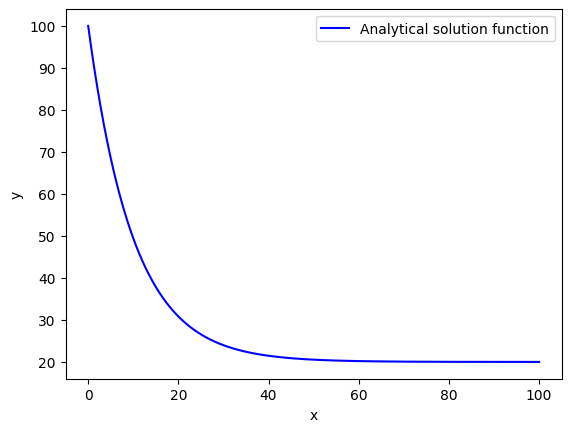

In [6]:
## Comparing model versus analytical solution
# Draw x using a linspace
x = torch.linspace(0, 100, steps = 1000).view(-1, 1).requires_grad_(True).to(device)
# Detach and convert to numpy for matplotlib
xs = x.cpu().detach().numpy()

# Comparing model vs. analytical solution
plt.plot(xs, sol_fun(xs), "b-", label = "Analytical solution function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc = "best")
plt.show()

### An approximate solution to the PDE using a PINN

In this Notebook, we will assume that the PDE cannot be simply resolved analytically and will train the PINN as an approximator for the analytical solution shown above.

We will start by defining a NN, which will take one input (a time value $ t $), will include a few linear layers, activation functions as ReLU, and will finish with a single linear output layer, which produces a single output, being an approximation of the temperature at time $ t $.

In other words, the PINN will have to learn how to map the time $ t $ to the temperature $ T(t) $ and will therefore learn approximate the function $ T(t) = T_{env} + (T_0 - T_{env}) \exp(-Rt) $, without any information about it, except for the PDE that it is supposed to be the solution of.

We start by defining our NN class below

In [7]:
class LinearNN(nn.Module):
    def __init__(self, num_layers = 5, num_neurons = 128):
        # Start with attributes.
        super().__init__()
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        # Build layers.
        layers = []
        # First layer.
        layers.append(nn.Linear(1, self.num_neurons))
        # Hidden layers will consist of Linear layers and some activation.
        for _ in range(self.num_layers):
            layers.append(nn.Linear(self.num_neurons, self.num_neurons))
            layers.append(nn.ReLU())
        # Finish with one output layer, which is simply a linear and has no activation.
        layers.append(nn.Linear(self.num_neurons, 1))

        # Build the network as a Sequential object of the layers.
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Forward method made simple, using the Sequential object from earlier.
        return self.network(x.reshape(-1, 1)).squeeze()

In [8]:
model = LinearNN().to(device)

At the moment, the model is untrained, so we are not surprised to see a random output being produced by our model for a sequence of times $ t $.

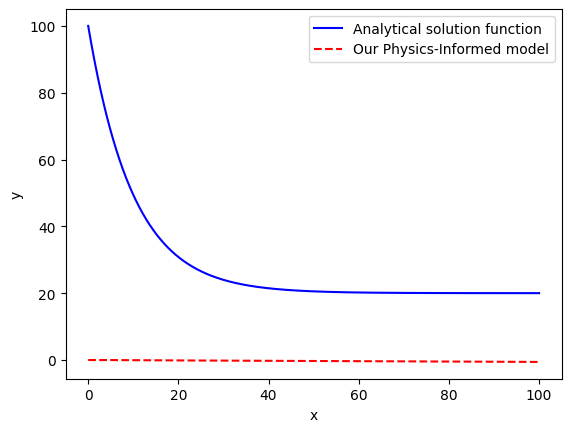

In [9]:
## Comparing model versus analytical solution
# Draw x using a linspace
x = torch.linspace(0, 100, steps = 1000).view(-1, 1).requires_grad_(True).to(device)
# Detach and convert to numpy for matplotlib
xs = x.cpu().detach().numpy()
# Use model to predict on x
y = model(x)
# Detach and convert to numpy for matplotlib
ys = y.cpu().detach().numpy()

# Comparing model vs. analytical solution
plt.plot(xs, sol_fun(xs), "b-", label = "Analytical solution function")
plt.plot(xs, ys, "r--", label = "Our Physics-Informed model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc = "best")
plt.show()

### Training the PINN as a PDE approximator using a custom Physics loss function

In order to train the Neural Network, we will have to design a loss function, which encourages the PINN to implement a function that solves the PDE.

In order to design such a loss function, we will first define a *grad_fun()*, which produces the derivative of the function produced by model. This can be simply done, using the autograd, as shown below.

In [10]:
# This function will compute gradients with respect to inputs,
# for the given forward pass that produced the respective outputs.
def grad_fun(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs = torch.ones_like(outputs), create_graph = True)

Second, we will design a Physics loss function, whose behavior is to encourage the PINN to adjust parameters in such a way that the function connecting the inputs $ t $ and outputs $ f(t) $ of the model $ f $, consists of a function that "solves" the PDE.

Going back to our PDE, the model will consist of a godd approximation of the analytical solution, if the model solves the following two equations

$$ \frac{dT(t)}{dt} = R(T_{env} - T(t)) $$

$$ T(0) = 20 $$

We will therefore design a loss with two components: a PDE loss and an Initial Condition (IC) loss.

The first loss, the PDE loss, should encourage the model to use parameters such that this condition $ \frac{dT(t)}{dt} = R(T_{env} - T(t)) $ is met.

This can be rewritten as $ \frac{dT(t)}{dt} - R(T_{env} - T(t)) = 0 $. In order to encourage the model to choose parameters such that $ grad_f(t) - R(T_{env} - f(t)) $ goes to zero, we can consider the PDE loss $ V_1 $ below, consisting of the square value of the difference.

$$ V_1 = \frac{1}{N} \sum_{i=0}^N \big( grad_f(t_i) - R(T_{env} - f(t_i)) \big)^2 $$

Here, the $ t_i $ value will be simply defined as the $ i$-th value of the linspace between 0 and $ t_{max} = 100 $. Using this (MSE?) function $ V_1 $ as a loss and minimizing it, will encourage the model to choose parameters that make the difference $ \frac{dT(t)}{dt} - R(T_{env} - T(t)) $ equal to 0, or in other words, make the neural network $ f $ a solution to the PDE.

There is also a second equation, the initial condition one, that needs to be satisfied by the model. Following the same logic, we will define an IC loss, $ V_2 $ as shown below.

$$ V_2 = \big( T_0 - f(0)) \big)^2 $$

Eventually, we will assemble both losses, into a Physics loss function $ L $ shown below.

$$ L = 1 + \lambda_1 V_1 + \lambda_2 V_2 $$

As before with regularization, the $ \lambda $ terms are used to decide the importance of each component in the assembled loss $ L $. For simplicity, we will make both $ \lambda $ values equal to 1, but they are technically hyperparameters that we should probably play with. The constant 1 value being added here, only serves later on for visualization, as we will represent the loss in log10 scale (and obviously we do not want a scenario where the loss goes to zero).

Our custom loss function is shown below.

In [11]:
# This is the custom loss function we plan to use for the model
def physics_loss(model):
    # Generate x tensor by drawing with a linspace
    t = torch.linspace(0, 100, steps = 1000).view(-1, 1).requires_grad_(True).to(device)

    # Forward pass
    y = model(t)
    # Compute the gradient manually
    dy = grad_fun(y, t)[0]
    
    # Compute the loss
    # Val1: checks if the model fits the PDE
    # Val2: checks if the model fits the initial condition
    # Lambda_coeffs: serves the same purpose as in regularization, to indicate
    # the importance of one aspect of the loss (e.g. val1) wrt. the second part (e.g. val2).
    # Note: technically, lambda_coeff is an hyperparameter
    # and we should investigate different values!
    right_hand_side_pde = (R_coeff*(T_env - y)).view(dy.shape)
    val1 = torch.mean((dy - right_hand_side_pde)**2)
    X_0 = torch.linspace(0, 0, steps = 1).view(-1, 1).requires_grad_(True).to(device)
    Y_0 = model(X_0)
    GT_0 = sol_fun_torch(X_0).view(Y_0.shape)
    val2 = torch.mean((Y_0 - GT_0)**2)
    lambda_coeff1 = 1
    lambda_coeff2 = 1
    # Return assembled loss value
    # Also returns val1 and val2 for visualization
    return 1 + lambda_coeff1*val1 + lambda_coeff2*val2, val1, val2

Our model is currently untrained, so it obviously has a terrible performance according to this loss. More specifically, the $ V_2 $ value is huge as the model is not able to meet the IC requirements at the moment.

In [12]:
# Our loss has a certain value, which is not necessarily zero
# (This is normal, given that the model is untrained!)
model = LinearNN().to(device)
loss, val1, val2 = physics_loss(model)
print(loss)
print(val1)
print(val2)

tensor(10020.4707, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9314, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10015.5391, device='cuda:0', grad_fn=<MeanBackward0>)


### Using our Physics loss to train the PINN

Eventually, we will use the physics loss function above to train our PINN. Notice how this loss function does not require a dataset, as it is only using the elements of the PDEs.

Our traaining procedure is basic:
- Adam with Learning Rate at $ 1e-3 $, and a decay on the learning rate based on the number of iterations,
- 30000 iterations,
- Our custom loss function being minimized.

We run the training loop below.

In [13]:
# Choose parameters for the training, as before
num_iter = 30001
learning_rate = 1e-3

In [14]:
### Training loop
# Reset model
model = LinearNN().to(device)

# Choose an optimizer, let us be original (!) and use Adam
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Keep track of loss values
loss, val1, val2 = physics_loss(model)
loss_values = [loss.item()]
val1_values = [val1.item()]
val2_values = [val2.item()]

for i in range(num_iter):
    # Learning rate adjustment (using a decay based on iterations)
    decay = 1 + 10*i//1000
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate/decay)
    
    # Forward pass: Compute the loss
    loss, val1, val2 = physics_loss(model)
    
    # Zero the gradients
    optimizer.zero_grad()
    # Backward pass: Compute gradient of the loss with respect to model parameters
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    
    if i % 10 == 0:
        # Add to list every 10 iterations
        loss_values.append(loss.item())
        val1_values.append(val1.item())
        val2_values.append(val2.item())
        if i % 500 == 0:
            # Print progress every 500 iterations
            print(f"Iteration {i}, Combined Loss: {loss.item()}, PDE part: {val1.item()}, Init Cond. part: {val2.item()}")

Iteration 0, Combined Loss: 9999.5478515625, PDE part: 3.945091724395752, Init Cond. part: 9994.6025390625
Iteration 500, Combined Loss: 12.37597370147705, PDE part: 0.31052419543266296, Init Cond. part: 11.065449714660645
Iteration 1000, Combined Loss: 3.7396931648254395, PDE part: 0.08377191424369812, Init Cond. part: 2.655921220779419
Iteration 1500, Combined Loss: 2.240907669067383, PDE part: 0.04840404540300369, Init Cond. part: 1.192503571510315
Iteration 2000, Combined Loss: 1.719172477722168, PDE part: 0.06091175228357315, Init Cond. part: 0.6582607626914978
Iteration 2500, Combined Loss: 1.45290207862854, PDE part: 0.028095940127968788, Init Cond. part: 0.424806147813797
Iteration 3000, Combined Loss: 1.3541643619537354, PDE part: 0.024437135085463524, Init Cond. part: 0.3297271728515625
Iteration 3500, Combined Loss: 1.2351912260055542, PDE part: 0.022242285311222076, Init Cond. part: 0.2129489630460739
Iteration 4000, Combined Loss: 1.2030709981918335, PDE part: 0.0210985280

As expected, the loss will eventually drop to 1, because both components of the loss function, namely $ V_1 $ and $ V_2 $ will go to zero.

### Evaluating the PINN

Below, we will show the training curves for $ V_1 $, $ V_2 $ and $ L $. We also show a superposition of the function $ T(t) $ being the analytical solution to the PDE, along with the function $ f(t) $ being produced by the model.

While it took several iterations for the model to train and learn to approximate the analytical solution to this PDE, it eventually figured it out nicely, without having to rely on any information but the PDE itself.

As such, the PINN acts as an interesting approximator for the PDE.

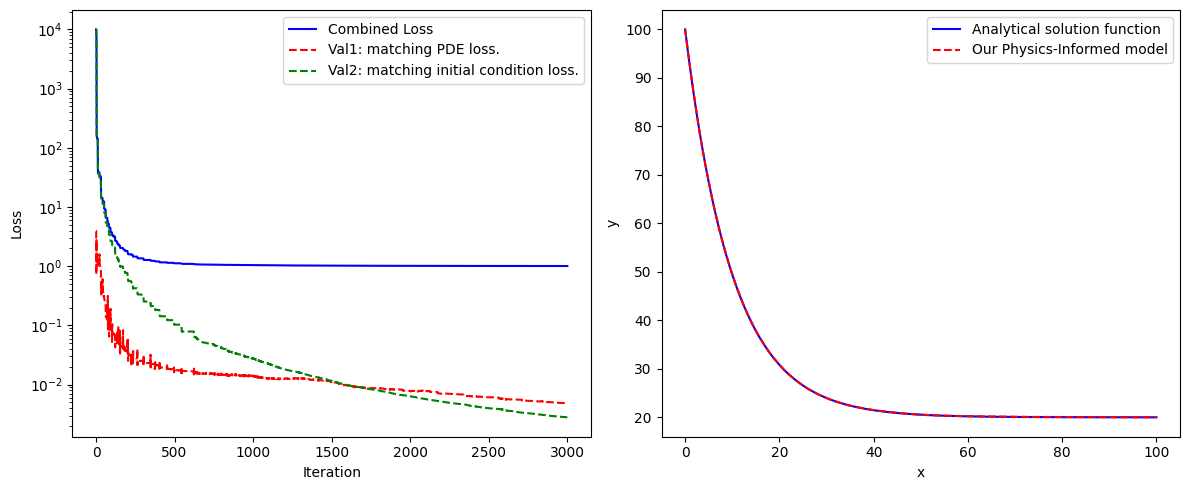

In [15]:
# First subplot: Training curves for loss
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1) 
plt.plot(loss_values, "b", label = "Combined Loss")
plt.plot(val1_values, "r--", label = "Val1: matching PDE loss.")
plt.plot(val2_values, "g--", label = "Val2: matching initial condition loss.")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc = "best")

## Comparing model versus analytical solution
# Draw x using a linspace
x = torch.linspace(0, 100, steps = 1000).view(-1, 1).requires_grad_(True).to(device)
# Detach and convert to numpy for matplotlib
xs = x.cpu().detach().numpy()
# Use model to predict on x
y = model(x)
# Detach and convert to numpy for matplotlib
ys = y.cpu().detach().numpy()
# Second subplot: Comparing model vs. analytical solution
plt.subplot(1, 2, 2)
plt.plot(xs, sol_fun(xs), "b-", label = "Analytical solution function")
plt.plot(xs, ys, "r--", label = "Our Physics-Informed model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc = "best")

# Display the combined plots
plt.tight_layout()
plt.show()

### What is next?

In the next notebook, we will explore the impact of feature engineering on PINNs.